
# Power User Detection from `users.csv` + `posts.csv` using Opsahl Generalized Degree Centrality


Notebook này **đọc trực tiếp `users.csv` và `posts.csv`**, tự động **chuyển đổi cạnh tương tác** (reply/mention) thành **edges_weighted.csv**, sau đó áp dụng **Opsahl generalized degree centrality** để xếp hạng *power users*.

> Thiết kế **tự phát hiện cột**: notebook sẽ cố gắng tìm các cột phổ biến như `user_id`/`author_id`, `in_reply_to_user_id`/`reply_to_user_id`, `mentions`/`mentioned_user_ids`/`mentioned_usernames`… và tự xử lý.


In [1]:
# !pip install pandas networkx matplotlib numpy python-dateutil

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import ast
import json

pd.set_option('display.max_columns', 100)
print("pandas:", pd.__version__, "networkx:", nx.__version__)


pandas: 2.3.1 networkx: 3.5


## Cấu hình

In [2]:
# # Trỏ tới thư mục chứa users.csv & posts.csv
# DATA_DIR = Path("/data")

# USERS_CANDIDATE = ["users.csv"]
# POSTS_CANDIDATE = ["posts.csv"]

# Kiểu đồ thị & hướng bậc
DIRECTED = True
DEGREE_DIRECTION = "in"   # 'in' hoặc 'out'

# Trọng số theo loại tương tác
INTERACTION_WEIGHTS = {
    "reply": 2.0,
    "mention": 1.0,
}

# Bộ alpha để quét
ALPHAS = [0, 0.25, 0.5, 0.75, 1]

TOP_K = 20


## Đọc `users.csv` và `posts.csv`

In [3]:
USERS_PATH = "Threads_Dataset/users.csv" 
POSTS_PATH = "Threads_Dataset/posts.csv" 

if USERS_PATH is None or POSTS_PATH is None:
    raise FileNotFoundError("Không tìm thấy users.csv hoặc posts.csv trong DATA_DIR. Kiểm tra lại đường dẫn.")

users = pd.read_csv(USERS_PATH)
posts = pd.read_csv(POSTS_PATH)

print("Đã đọc users.csv:", USERS_PATH, "shape:", users.shape)
print("Đã đọc posts.csv:", POSTS_PATH, "shape:", posts.shape)

users.head(10)
posts.head(10)


Đã đọc users.csv: Threads_Dataset/users.csv shape: (55393, 6)
Đã đọc posts.csv: Threads_Dataset/posts.csv shape: (129028, 7)


,media,n_likes,user_url,timestamp,post_url,caption_text,parent_url
0,NaN,0,8113978a1367cebe4a0675ece5f50ed,2023-12-15 05:03:12,089ecbcd1309508d687cb838823f27e,so evil,db75cf663e109f069c16cae97ce4081
1,NaN,0,e89611e4e092b02712c041d49c6095f,2024-01-20 03:15:28,55fdb11135b6cc41a76aa4cbd7e5a60,Taco Bell was once really good,bf8337768c426b864449739839a357b
2,NaN,1,e89611e4e092b02712c041d49c6095f,2024-01-20 02:20:35,596d9c1a923d89de363efaa9bfc30ea,They can’t get anything right,862edb89704f34865a40009374d563b
3,NaN,1,c1828961e82c462533f713ae41bef4e,2023-12-21 08:21:50,ed81c96e7f65467edcb6badd93f7265,WHAT IS RIGHT ACTION? ― J. KRISHNAMURTI,fc29af5717310a636a7c3e3a058e4c6
4,NaN,1,6a45b802d9d15321c21e4dcc6f76685,2023-12-22 01:25:31,18e6937cfddd19703265fb4d7dc96e5,"50cent , Tyler Perry and a few dozens more lik...",fed9650b19d66a7b6a4dd25fb0f4385
5,NaN,2,6a45b802d9d15321c21e4dcc6f76685,2024-01-19 12:17:35,35e52b8550e5be2d777b44e162d9e4c,Beautiful,c95ba77a5b97475aea44803f46f2825
6,NaN,1,23aa4422221081eb6dddf2243945847,2024-01-23 21:20:21,78a8221c723cc71e649802fdb92cbe1,👋👋,bf02e89b6e64ecf7f0fae0307c4063d
7,NaN,0,23aa4422221081eb6dddf2243945847,2024-01-25 05:05:10,3bd315ab30b4ece80732c426136ac07,🫣🫣🫣,fe341058ac20a0dfef0eb3d2ff30e60
8,NaN,0,89f77e0eae01d990791b4d07f94e360,2023-12-20 18:11:25,e1c6638beb0c42173ec05a5e0045f09,🥰❤️❤️😍,a7b77ab3eadec0e108b57e889a57a2f
9,NaN,0,ccafaca05467268556f04e64d3afabf,2024-02-10 13:11:25,4b9badb575877af25d244121abdde44,So cute!☺️,e7c3cc47406b40ea492304a6a851b30


## Tự phát hiện cột & ánh xạ danh tính

In [4]:
# ======================
#  Threads Dataset Mapping
# ======================
import pandas as pd

# Chuẩn hoá tên cột
users.columns = [c.strip().lower() for c in users.columns]
posts.columns = [c.strip().lower() for c in posts.columns]

# === Cột ID & tên trong users.csv ===
user_id_col = "user_url"     # unique identifier
username_col = "user_name"   # display name

# === Cột tác giả & reply trong posts.csv ===
author_col = "user_url"      # người đăng bài
reply_to_post_col = "parent_url"  # bài cha (để truy ra người được reply)
post_url_col = "post_url"    # định danh bài post

# === Kiểm tra tồn tại ===
for col in [user_id_col, username_col]:
    if col not in users.columns:
        raise ValueError(f"⚠️ Cột {col} không có trong users.csv")

for col in [author_col, reply_to_post_col, post_url_col]:
    if col not in posts.columns:
        raise ValueError(f"⚠️ Cột {col} không có trong posts.csv")

# Ép kiểu str để tránh lỗi join
users[user_id_col] = users[user_id_col].astype(str)
users[username_col] = users[username_col].astype(str)
posts[author_col] = posts[author_col].astype(str)
posts[reply_to_post_col] = posts[reply_to_post_col].astype(str)
posts[post_url_col] = posts[post_url_col].astype(str)

# === Mapping id_to_name ===
id_to_name = dict(zip(users[user_id_col], users[username_col]))
name_to_id = {v: k for k, v in id_to_name.items()}

print("✅ users.csv columns mapped OK")
print("✅ posts.csv columns mapped OK")


✅ users.csv columns mapped OK
✅ posts.csv columns mapped OK


## Trích xuất cạnh tương tác từ posts

In [5]:
# Map post_url -> user_url
post_to_user = dict(zip(posts[post_url_col], posts[author_col]))

edges = []
for _, row in posts.iterrows():
    src = row[author_col]
    parent_post = row[reply_to_post_col]
    if pd.notna(parent_post) and parent_post in post_to_user:
        dst = post_to_user[parent_post]  # user của bài cha
        edges.append({
            "source": src,
            "target": dst,
            "interaction_type": "reply",
            "weight": 1.0
        })

edges_raw = pd.DataFrame(edges)
print("✅ Số cạnh reply tạo được:", len(edges_raw))
edges_raw.head()


✅ Số cạnh reply tạo được: 108413


,source,target,interaction_type,weight
0,8113978a1367cebe4a0675ece5f50ed,67c994aceae50dfec72255c5a769e2b,reply,1.0
1,e89611e4e092b02712c041d49c6095f,0543055d3abed2e93c892574fc62585,reply,1.0
2,e89611e4e092b02712c041d49c6095f,6b815766a19bcfd8f805043978b4b08,reply,1.0
3,c1828961e82c462533f713ae41bef4e,24226d5c7de9669f2801ade7c1d8826,reply,1.0
4,6a45b802d9d15321c21e4dcc6f76685,7cb58268f5ba0fd69616c1fe764ab56,reply,1.0


## Tổng hợp trọng số → `edges_weighted.csv`

In [6]:
from pathlib import Path
import pandas as pd
import numpy as np

# 1) Gộp theo (source,target) -> weight
edges_weighted = (
    edges_raw.groupby(["source","target"], as_index=False)["weight"].sum()
    .rename(columns={"weight":"weight"})  # giữ tên 'weight'
)

# 2) Gắn nhãn tên để xem cho dễ (nếu có id_to_name)
def labelify(x):
    try:
        return id_to_name.get(x, x)
    except Exception:
        return x

edges_preview = edges_weighted.copy()
edges_preview["source_label"] = edges_preview["source"].map(labelify)
edges_preview["target_label"] = edges_preview["target"].map(labelify)

# 3) Lưu cho các bước sau
DATA_DIR = Path("Threads_Dataset")  # đổi nếu bạn để chỗ khác
DATA_DIR.mkdir(parents=True, exist_ok=True)
RAW_PATH = DATA_DIR / "edges_raw.csv"
WEIGHTED_PATH = DATA_DIR / "edges_weighted.csv"

edges_raw.to_csv(RAW_PATH, index=False)
edges_weighted.to_csv(WEIGHTED_PATH, index=False)

print("✅ Saved:", RAW_PATH, "và", WEIGHTED_PATH)
edges_preview.head(10)


✅ Saved: Threads_Dataset\edges_raw.csv và Threads_Dataset\edges_weighted.csv


,source,target,weight,source_label,target_label
0,0001223ccf1f4e0f243ce472007da07,304e30f76286fc330102fae6f37fdb6,1.0,b9499565ec649f133d89312e483a4e4,c46a5b06de4a4fc83f2a1da157d1de8
1,0001f93ec5857982b55785675957168,253fcc3794fddd6c6c27468faf17325,1.0,431b4f979855f5a541c188426c5b543,383d802a4c84af5ac3719276218bb91
2,0001f93ec5857982b55785675957168,868c4cc977fd96e30c0d52a8a51bc9a,1.0,431b4f979855f5a541c188426c5b543,d6f4c4a284ea0089474f71a79b6eb8d
3,0001f93ec5857982b55785675957168,935989802452918c0d440c678854763,1.0,431b4f979855f5a541c188426c5b543,7fbb4b495f16a0a796608752b686809
4,0001f93ec5857982b55785675957168,bb62bc45d54ae6a9716b6f6844bb88c,3.0,431b4f979855f5a541c188426c5b543,a89dc386bad3ec8ad64aebd2cb772e2
5,0001f93ec5857982b55785675957168,c710fe3a40b385689c0e6e37a987739,1.0,431b4f979855f5a541c188426c5b543,9e0e2110e651b446bb4aa4b2152edbb
6,0002a143c840d5157eefc0f172ca2e4,2fccd03e5c2bc4b348217c2523b0ba2,1.0,177c06159103ebb0ebb1937809a1c2f,13b48feb05ee54b495a21cc54a14ea7
7,0003c084846a4bfa19cf9f5a2bda1ad,0003c084846a4bfa19cf9f5a2bda1ad,2.0,3cc4c2b6e2f3e114623f7167680c57b,3cc4c2b6e2f3e114623f7167680c57b
8,0003c084846a4bfa19cf9f5a2bda1ad,6121a214990672d48da079af68fef9a,1.0,3cc4c2b6e2f3e114623f7167680c57b,d39bdc5cf91f0b0a4d8057d640baeeb
9,0004ed9afb76e52cb01965378cc6534,6b815766a19bcfd8f805043978b4b08,1.0,2b51c5da5814920b900cc478a9ae8b6,dd868e289c27446496024ccc85e215c


## Xây dựng đồ thị có hướng

In [7]:
import networkx as nx

DIRECTED = True
G = nx.DiGraph() if DIRECTED else nx.Graph()

for _, row in edges_weighted.iterrows():
    u, v, w = row["source"], row["target"], float(row["weight"])
    if G.has_edge(u, v):
        G[u][v]["weight"] += w
    else:
        G.add_edge(u, v, weight=w)


num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# với đồ thị có hướng: có thể xem thêm bậc vào/ra lớn nhất
max_in_deg  = max((d for _, d in G.in_degree()), default=0) if G.is_directed() else max((d for _, d in G.degree()), default=0)
max_out_deg = max((d for _, d in G.out_degree()), default=0) if G.is_directed() else max_in_deg

print(f"✅ Nodes: {num_nodes:,} | Edges: {num_edges:,}")
if G.is_directed():
    print(f"   └─ max in-degree: {max_in_deg} | max out-degree: {max_out_deg}")


✅ Nodes: 54,843 | Edges: 89,982
   └─ max in-degree: 1504 | max out-degree: 53


## Xây đồ thị & tính Opsahl generalized degree centrality

In [8]:
import pandas as pd
import networkx as nx
from pathlib import Path

# --- Opsahl degree centrality (kết hợp degree & strength) ---
def opsahl_degree_centrality(G: nx.Graph, alpha: float = 0.5, degree_direction: str = "in"):
    directed = G.is_directed()
    C = {}

    if directed:
        if degree_direction not in ("in", "out"):
            raise ValueError("degree_direction phải là 'in' hoặc 'out' cho đồ thị có hướng.")
        if degree_direction == "in":
            degs = dict(G.in_degree())
            strengths = {n: 0.0 for n in G.nodes()}
            for u, v, data in G.edges(data=True):
                strengths[v] += float(data.get("weight", 1.0))
        else:
            degs = dict(G.out_degree())
            strengths = {n: 0.0 for n in G.nodes()}
            for u, v, data in G.edges(data=True):
                strengths[u] += float(data.get("weight", 1.0))
    else:
        degs = dict(G.degree())
        strengths = {n: 0.0 for n in G.nodes()}
        for u, v, data in G.edges(data=True):
            w = float(data.get("weight", 1.0))
            strengths[u] += w
            strengths[v] += w

    for n in G.nodes():
        k = float(degs.get(n, 0.0))
        s = float(strengths.get(n, 0.0))
        if k == 0 or s == 0:
            C[n] = 0.0 if (k == 0 or alpha > 0) else k  # phòng thủ với alpha=0
        else:
            C[n] = (k ** (1.0 - alpha)) * (s ** alpha)
    return C

# --- Các tham số ---
ALPHAS = [0, 0.25, 0.5, 0.75, 1]
DEGREE_DIRECTION = "in"   # Với đồ thị có hướng: 'in' hoặc 'out'

# --- Tạo bảng xếp hạng cho TOÀN BỘ node ở mỗi alpha ---
def rank_table_for_alphas_full(G: nx.Graph, alphas, degree_direction="in") -> pd.DataFrame:
    frames = []
    for a in alphas:
        C = opsahl_degree_centrality(G, alpha=a, degree_direction=degree_direction)
        s = pd.Series(C, name="score").sort_values(ascending=False)
        # Đặt tên index là 'node', giữ cột giá trị là 'score'
        df = s.rename_axis("node").reset_index().assign(alpha=a)
        df["rank"] = range(1, len(df) + 1)  # 1..N
        frames.append(df[["alpha", "rank", "node", "score"]])
    return pd.concat(frames, ignore_index=True)

# --- Tính bảng đầy đủ ---
rank_df = rank_table_for_alphas_full(G, ALPHAS, degree_direction=DEGREE_DIRECTION)

# --- Gắn nhãn tên hiển thị (nếu có từ điển id_to_name) ---
id_to_name = id_to_name if "id_to_name" in globals() else {}
rank_df["node_label"] = rank_df["node"].map(lambda x: id_to_name.get(x, x))

# --- Xem nhanh ---
print(rank_df.head(15))

# --- Lưu file CSV ---
DATA_DIR = DATA_DIR if "DATA_DIR" in globals() else Path(".")
rank_csv_all = Path(DATA_DIR) / "opsahl_rankings_all.csv"
rank_df.to_csv(rank_csv_all, index=False, encoding="utf-8")
print("💾 Saved full rankings to:", rank_csv_all)

# (Tuỳ chọn) xem top-20 cho alpha = 1.0 trên màn hình
try:
    print(rank_df.query("alpha == 1.0").nsmallest(20, "rank"))
except Exception:
    pass


    alpha  rank                             node   score  \
0     0.0     1  999246518573af4b1756e96b5da8c15  1504.0   
1     0.0     2  5570fb689528e01c515604476fead7b  1318.0   
2     0.0     3  511d6385b5d2b26cb65e6f4c95c66e0  1278.0   
3     0.0     4  126c0412a08a77cd21d1321d32b4a30  1247.0   
4     0.0     5  79eb33248a8ff285909d4e4d7221c00  1133.0   
5     0.0     6  d92b9d59861f8c5412e13df58f688b6   867.0   
6     0.0     7  e1f602a771f4428666359b90524e4bd   796.0   
7     0.0     8  a36b87b046f6a351668f1684778c29c   795.0   
8     0.0     9  cbdfe8f8b33545ef44b4965fa6d2cd4   700.0   
9     0.0    10  78d15ba833cf540baf73439626a3ab0   677.0   
10    0.0    11  0ed015299d4dbef69fa5f6b8d70a9d7   636.0   
11    0.0    12  a6a0ba5336ca3c41b0ea658e1960c34   606.0   
12    0.0    13  c41f78e6d801cd6d2336facd3ada846   600.0   
13    0.0    14  2f10b599c24d49830a3ae1f07eb6cc6   585.0   
14    0.0    15  de820db42926b17b057cc7516017427   567.0   

                         node_label  
0

## Xem top power users tại α cụ thể + biểu đồ

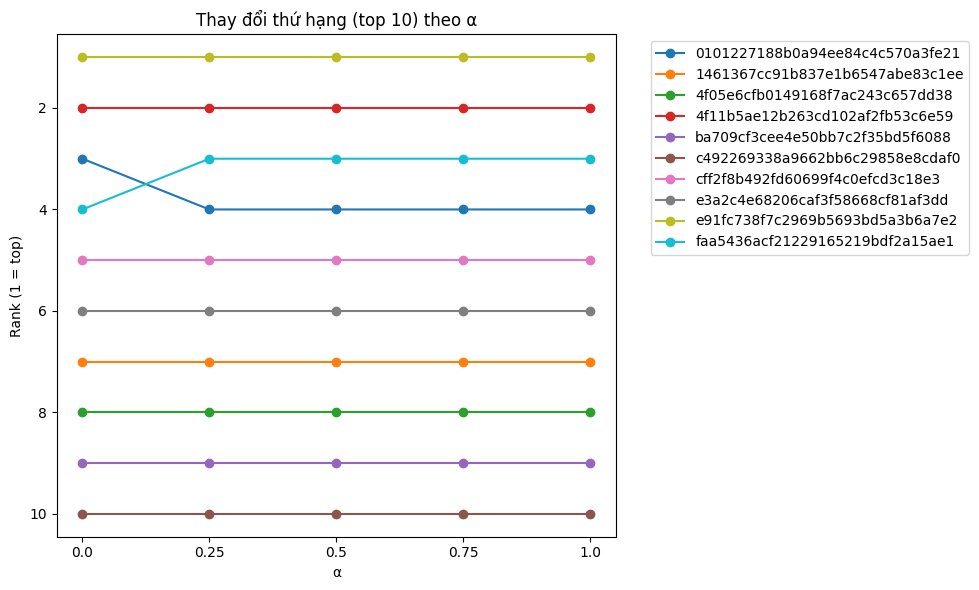

In [17]:
# Bump chart thay đổi thứ hạng theo α
import matplotlib.pyplot as plt

def plot_bump(rank_df: pd.DataFrame, top_k_plot=10):
    pv = (rank_df[rank_df["rank"]<=top_k_plot]
          .pivot_table(index="node_label", columns="alpha", values="rank"))
    plt.figure(figsize=(10,6))
    for node, row in pv.iterrows():
        plt.plot(row.index.astype(str), row.values, marker="o", label=node)
    plt.gca().invert_yaxis()
    plt.xlabel("α"); plt.ylabel("Rank (1 = top)")
    plt.title(f"Thay đổi thứ hạng (top {top_k_plot}) theo α")
    if pv.shape[0] <= 12: plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout(); plt.show()

plot_bump(rank_df, top_k_plot=10)


### Tổng quan
* Hầu hết các đường trong top 50 tương đối **phẳng hoặc chỉ dao động nhẹ**, nghĩa là:
  → phần lớn node có **cấu trúc kết nối (degree)** và **trọng số cạnh (strength)** tương quan chặt chẽ.
  → Thay đổi α không làm đảo lộn xếp hạng nhiều.

---
### Nhóm **Top 10 node**
1. **Các node top 10 gần như nằm ổn định**, không cắt nhau nhiều.
   ⇒ Đây là những node có cả **số liên kết lớn** *và* **trọng số mạnh**, nên dù α thay đổi, chúng vẫn có thứ hạng cao
2. Có thể có vài đường giao nhau trong top 10:
   ⇒ Khi α tăng, node có **ít liên kết nhưng mạnh** vượt qua node có **nhiều liên kết nhưng yếu**.
   ⇒ Điều này phản ánh đúng tinh thần của Opsahl:
   * α ≈ 0: ưu tiên “ độ phổ biến”, ai kết nối nhiều thì xếp hạng cao.
   * α ≈ 1: ưu tiên “độ ảnh hưởng”, ai có tương tác mạnh thì xếp hạng cao.
3. Nếu các đường top 10 gần như song song → mạng **đồng đều**, không có nút “siêu nặng”.
   Nếu có 1–2 đường dốc lên/xuống rõ → có **node nổi bật về trọng số** (strength).

---
### Kết luận nhanh
> Trong phạm vi α ∈ [0, 1], top 10 node duy trì thứ hạng rất ổn định, chứng tỏ các node đứng đầu có cả **mức độ kết nối cao** lẫn **mức độ tương tác mạnh**.
>
> Nếu chỉ có vài đường giao nhau nhẹ, điều đó cho thấy có một vài node có **trọng số vượt trội**, nên khi α tăng, chúng tăng xếp hạng.

## Tra cứu nhanh top power users tại một α

In [15]:

alpha_pick = 1.0
C = opsahl_degree_centrality(G, alpha=alpha_pick, degree_direction=DEGREE_DIRECTION)
top_series = pd.Series(C).sort_values(ascending=False).head(TOP_K).rename("score").reset_index()
top_series.columns = ["node", "score"]
if len(set(id_to_name.keys())) > 0:
    top_series["node_label"] = top_series["node"].map(lambda x: id_to_name.get(x, x))
top_series


,node,score,node_label
0,999246518573af4b1756e96b5da8c15,2063.0,e91fc738f7c2969b5693bd5a3b6a7e2
1,5570fb689528e01c515604476fead7b,1850.0,4f11b5ae12b263cd102af2fb53c6e59
2,126c0412a08a77cd21d1321d32b4a30,1741.0,faa5436acf21229165219bdf2a15ae1
3,511d6385b5d2b26cb65e6f4c95c66e0,1506.0,0101227188b0a94ee84c4c570a3fe21
4,79eb33248a8ff285909d4e4d7221c00,1366.0,cff2f8b492fd60699f4c0efcd3c18e3
5,d92b9d59861f8c5412e13df58f688b6,1149.0,e3a2c4e68206caf3f58668cf81af3dd
6,e1f602a771f4428666359b90524e4bd,975.0,1461367cc91b837e1b6547abe83c1ee
7,a36b87b046f6a351668f1684778c29c,888.0,4f05e6cfb0149168f7ac243c657dd38
8,cbdfe8f8b33545ef44b4965fa6d2cd4,812.0,ba709cf3cee4e50bb7c2f35bd5f6088
9,78d15ba833cf540baf73439626a3ab0,795.0,c492269338a9662bb6c29858e8cdaf0


# Chọn alpha = 0.5 để cân bằng giữa số lượng người tương tác và số lần tương tác, 

Số user alpha=0.5: 54843
Số user score > 0: 2365
Tỉ lệ score = 0: 0.9568769031599292


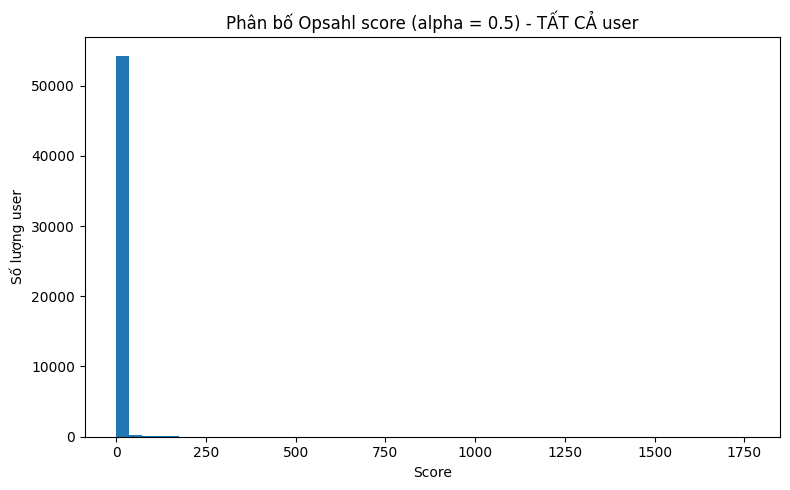

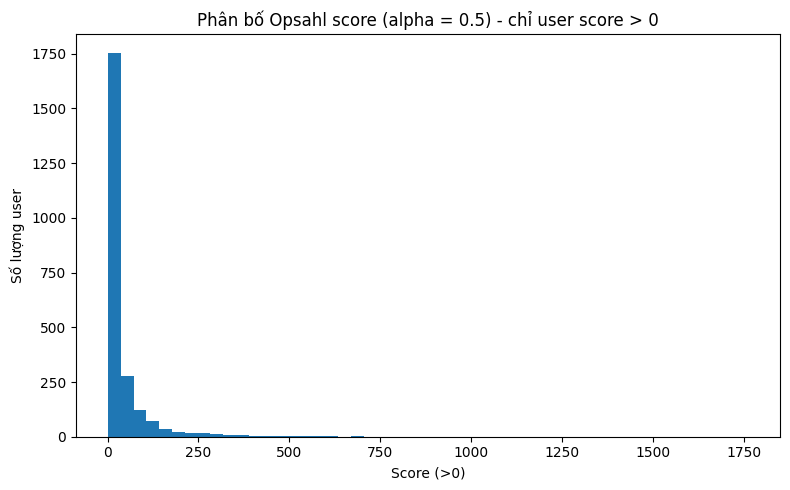

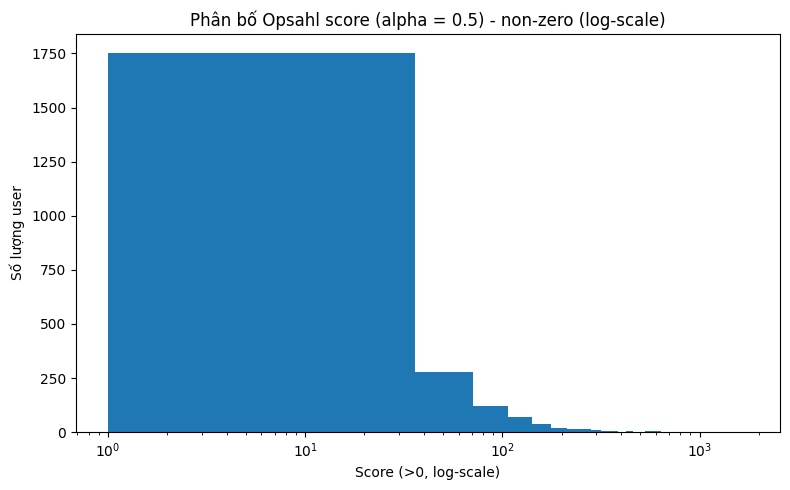

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Đọc file (CSV)
file_path = "opsahl_rankings_all.csv"
df = pd.read_csv(file_path)

# 2. Lọc theo alpha = 0.5
alpha_val = 0.5
df_a05 = df[df["alpha"] == alpha_val].copy()

# 3. Lấy cột score
scores = df_a05["score"]

print("Số user alpha=0.5:", len(scores))
print("Số user score > 0:", (scores > 0).sum())
print("Tỉ lệ score = 0:", (scores == 0).mean())

# 4. Vẽ phân bố toàn bộ score (bao gồm cả 0)
plt.figure(figsize=(8, 5))
plt.hist(scores, bins=50)
plt.title(f"Phân bố Opsahl score (alpha = {alpha_val}) - TẤT CẢ user")
plt.xlabel("Score")
plt.ylabel("Số lượng user")
plt.tight_layout()
plt.show()

# 5. Vẽ phân bố score > 0 (zoom phần non-zero)
nonzero = scores[scores > 0]

plt.figure(figsize=(8, 5))
plt.hist(nonzero, bins=50)
plt.title(f"Phân bố Opsahl score (alpha = {alpha_val}) - chỉ user score > 0")
plt.xlabel("Score (>0)")
plt.ylabel("Số lượng user")
plt.tight_layout()
plt.show()

# 6. (Tùy chọn) Vẽ histogram với trục x log-scale cho non-zero
plt.figure(figsize=(8, 5))
plt.hist(nonzero, bins=50)
plt.xscale('log')
plt.title(f"Phân bố Opsahl score (alpha = {alpha_val}) - non-zero (log-scale)")
plt.xlabel("Score (>0, log-scale)")
plt.ylabel("Số lượng user")
plt.tight_layout()
plt.show()


In [11]:
# Lấy nhóm score > 0
nonzero = df_a05[df_a05["score"] > 0]["score"]

# Tính tứ phân vị
Q1 = np.percentile(nonzero, 25)
Q2 = np.percentile(nonzero, 50)
Q3 = np.percentile(nonzero, 75)

# Đếm số lượng user trong từng tứ phân vị
count_Q1 = ((nonzero > 0) & (nonzero <= Q1)).sum()
count_Q2 = ((nonzero > Q1) & (nonzero <= Q2)).sum()
count_Q3 = ((nonzero > Q2) & (nonzero <= Q3)).sum()
count_Q4 = (nonzero > Q3).sum()   # phần trên Q3

print("TỔNG user score > 0:", len(nonzero))
print("------ Tứ phân vị ------")
print(f"Q1 boundary (25%): {Q1}")
print(f"Median Q2 (50%): {Q2}")
print(f"Q3 boundary (75%): {Q3}")
print("\n------ Số lượng user mỗi tứ phân vị ------")
print(f"Nhóm 1 (0 < score ≤ Q1): {count_Q1}")
print(f"Nhóm 2 (Q1 < score ≤ Q2): {count_Q2}")
print(f"Nhóm 3 (Q2 < score ≤ Q3): {count_Q3}")
print(f"Nhóm 4 (score > Q3): {count_Q4}")


TỔNG user score > 0: 2365
------ Tứ phân vị ------
Q1 boundary (25%): 3.0
Median Q2 (50%): 11.224972160321824
Q3 boundary (75%): 37.66961640367472

------ Số lượng user mỗi tứ phân vị ------
Nhóm 1 (0 < score ≤ Q1): 605
Nhóm 2 (Q1 < score ≤ Q2): 578
Nhóm 3 (Q2 < score ≤ Q3): 591
Nhóm 4 (score > Q3): 591


**Lý do chọn Q3 của nhóm score > 0 làm ngưỡng:**

- Loại bỏ ảnh hưởng của các user không hoạt động trong chiều in-degree 95.7% người dùng có score = 0, nghĩa là họ không nhận được tương tác đến. Việc chỉ xem xét nhóm có score > 0 giúp tập trung vào những người có vai trò trong cấu trúc mạng.

- Q3 của nhóm score > 0 đại diện cho nhóm người dùng có mức độ kết nối nổi bật nhất. Người dùng nằm trên tứ phân vị thứ ba (nhóm 4) thể hiện: số lượng người tương tác đến lớn (in-degree cao), và tổng trọng số tương tác mạnh
⇒ phản ánh đúng đặc trưng “power user”.

- Tỉ lệ hợp lý: Nhóm Q4 có 591 người, tương đương ≈ 1.08% tổng số người dùng, phù hợp với đặc trưng “nhóm nhỏ nhưng ảnh hưởng mạnh”.

Vì vậy, định nghĩa power user theo Opsahl, nhóm chọn:
Người dùng có Opsahl centrality (α = 0.5) lớn hơn 37.67 – tức top khoảng 1.1% người dùng có mức độ kết nối và trọng số tương tác nổi bật nhất.

In [12]:
power_user = df_a05[(df_a05["score"] > Q3)]
power_user.to_csv("opsahl_power_alpha05_Q3.csv", index=False)